In [1]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

# Variational Autoencoder

The variational autoencoder (VAE) was described in its current form in [Kingma 2013](https://arxiv.org/abs/1312.6114). The model consists of an encoder/inference network $q_{\phi}(z|x)$ and a decoder/generative network $p_{\theta}(x|z)$. The main idea is that it is possible to both reconstruct and generate samples from from some input distribution by learning a variational distribution over the latent variable $z$.

<img src="../images/vae.png" width="300px"/>

The VAE therefore has a bottleneck structure, where the input $x$ is encoded into a latent variable $z$. New data can then be generated by feeding a latent code into the generator network - $\widehat{x} \sim p_{\theta}(z|x)$. The diagram above shows the generative model (right) and how the latent variable $z$ is inferred from $x$ (left).

Below we will instantiate a new variational autoencoder with this bottleneck structure consisting of a 2-layer encoder network turning an input MNIST image into a latent code: $784 \to 256 \to 128 \to 32$. We also have a decoder that performs the operation in reverse: $32 \to 128 \to 256 \to 784$.

In [2]:
from models import VariationalAutoencoder
from layers import GaussianSample
model = VariationalAutoencoder([784, 50, [500, 500]], activation_fn=torch.nn.Softplus, batch_norm=False).cuda()
model

../../semi-supervised/models/vae.py:237: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


VariationalAutoencoder(
  (encoder): Encoder(
    (first_dense): ModuleList(
      (0): Linear(in_features=784, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): Softplus(beta=1, threshold=20)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=500, out_features=50, bias=True)
      (log_var): Linear(in_features=500, out_features=50, bias=True)
    )
  )
  (decoder): Decoder(
    (first_dense): ModuleList(
      (0): Linear(in_features=50, out_features=500, bias=True)
    )
    (hidden): ModuleList(
      (0): Softplus(beta=1, threshold=20)
      (1): Linear(in_features=500, out_features=500, bias=True)
      (2): Softplus(beta=1, threshold=20)
    )
    (reconstruction): Linear(in_features=500, out_features=784, bias=True)
  )
)

Notice how the middle most layer consists of a `GaussianSample` layer, in which we turn the input digit into the parameters of a Normal distribution with parameters $\mu$ and $\sigma$. This allows us to use the *reparametrization trick* to sample from this distribution to introduce stochasticity into the network.

In [3]:
from torch.autograd import Variable

gaussian = GaussianSample(10, 1)
z, mu, log_var = gaussian(Variable(torch.ones(1, 10)))

print(f"sample {float(z.data):.2f} drawn from N({float(mu.data):.2f}, {float(log_var.exp().data):.2f})")

sample -0.09 drawn from N(0.09, 0.81)


In [4]:
from datautils import get_mnist, get_svhn

# _, train, validation, std = get_svhn(location="./", batch_size=256)
_, train, validation, mnist_mean, mnist_std = get_mnist(location="./", batch_size=100, labels_per_class=10, preprocess=False)


# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

def mse(r, x):
    return torch.sum(torch.pow(x - r, 2), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

/home/mwolczyk/miniconda3/envs/pytorch_nightly/lib/python3.7/site-packages/torch/nn/functional.py:1382: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0	L: 196.16


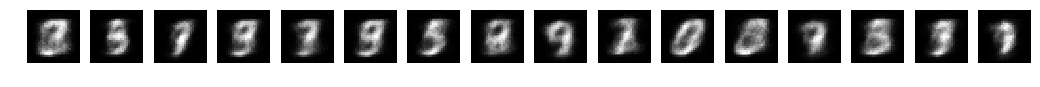

Epoch: 1	L: 153.71
Epoch: 2	L: 138.87
Epoch: 3	L: 129.26
Epoch: 4	L: 122.58
Epoch: 5	L: 118.33
Epoch: 6	L: 115.24
Epoch: 7	L: 113.06
Epoch: 8	L: 111.47
Epoch: 9	L: 110.15
Epoch: 10	L: 109.08
Epoch: 11	L: 108.14
Epoch: 12	L: 107.25
Epoch: 13	L: 106.57
Epoch: 14	L: 105.87
Epoch: 15	L: 105.28
Epoch: 16	L: 104.64
Epoch: 17	L: 104.21
Epoch: 18	L: 103.74
Epoch: 19	L: 103.31
Epoch: 20	L: 102.93
Epoch: 21	L: 102.55
Epoch: 22	L: 102.24
Epoch: 23	L: 101.90
Epoch: 24	L: 101.60
Epoch: 25	L: 101.32
Epoch: 26	L: 101.06
Epoch: 27	L: 100.84
Epoch: 28	L: 100.62
Epoch: 29	L: 100.45
Epoch: 30	L: 100.22
Epoch: 31	L: 100.03
Epoch: 32	L: 99.86
Epoch: 33	L: 99.69
Epoch: 34	L: 99.53
Epoch: 35	L: 99.37
Epoch: 36	L: 99.25
Epoch: 37	L: 99.10
Epoch: 38	L: 98.92
Epoch: 39	L: 98.80
Epoch: 40	L: 98.69
Epoch: 41	L: 98.56
Epoch: 42	L: 98.48
Epoch: 43	L: 98.31
Epoch: 44	L: 98.25
Epoch: 45	L: 98.13
Epoch: 46	L: 98.02
Epoch: 47	L: 97.91
Epoch: 48	L: 97.81
Epoch: 49	L: 97.72
Epoch: 50	L: 97.63


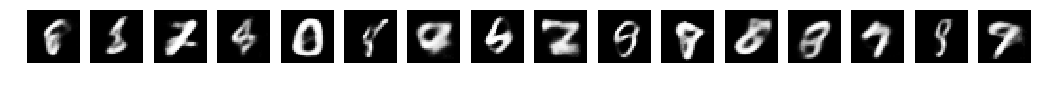

Epoch: 51	L: 97.53
Epoch: 52	L: 97.48
Epoch: 53	L: 97.38
Epoch: 54	L: 97.30
Epoch: 55	L: 97.20
Epoch: 56	L: 97.15
Epoch: 57	L: 97.07
Epoch: 58	L: 97.00
Epoch: 59	L: 96.93
Epoch: 60	L: 96.84
Epoch: 61	L: 96.83
Epoch: 62	L: 96.73
Epoch: 63	L: 96.68
Epoch: 64	L: 96.60
Epoch: 65	L: 96.54
Epoch: 66	L: 96.47
Epoch: 67	L: 96.40
Epoch: 68	L: 96.35
Epoch: 69	L: 96.33
Epoch: 70	L: 96.23
Epoch: 71	L: 96.20
Epoch: 72	L: 96.14
Epoch: 73	L: 96.12
Epoch: 74	L: 96.02
Epoch: 75	L: 96.00
Epoch: 76	L: 95.95
Epoch: 77	L: 95.90
Epoch: 78	L: 95.86
Epoch: 79	L: 95.80
Epoch: 80	L: 95.76
Epoch: 81	L: 95.71
Epoch: 82	L: 95.69
Epoch: 83	L: 95.65
Epoch: 84	L: 95.62
Epoch: 85	L: 95.57
Epoch: 86	L: 95.52
Epoch: 87	L: 95.50
Epoch: 88	L: 95.46
Epoch: 89	L: 95.39
Epoch: 90	L: 95.36
Epoch: 91	L: 95.31
Epoch: 92	L: 95.28
Epoch: 93	L: 95.26
Epoch: 94	L: 95.23
Epoch: 95	L: 95.20
Epoch: 96	L: 95.14
Epoch: 97	L: 95.10
Epoch: 98	L: 95.11
Epoch: 99	L: 95.04
Epoch: 100	L: 95.02


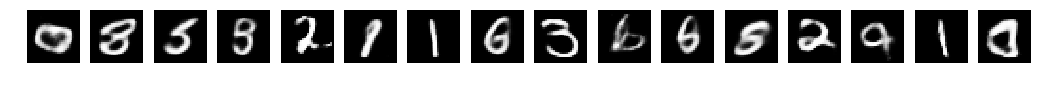

Epoch: 101	L: 95.01
Epoch: 102	L: 94.98
Epoch: 103	L: 94.92
Epoch: 104	L: 94.89
Epoch: 105	L: 94.86
Epoch: 106	L: 94.83
Epoch: 107	L: 94.80
Epoch: 108	L: 94.75
Epoch: 109	L: 94.77
Epoch: 110	L: 94.71
Epoch: 111	L: 94.69
Epoch: 112	L: 94.65
Epoch: 113	L: 94.69
Epoch: 114	L: 94.62
Epoch: 115	L: 94.59
Epoch: 116	L: 94.59
Epoch: 117	L: 94.54
Epoch: 118	L: 94.51
Epoch: 119	L: 94.50
Epoch: 120	L: 94.48
Epoch: 121	L: 94.44
Epoch: 122	L: 94.38
Epoch: 123	L: 94.34
Epoch: 124	L: 94.34
Epoch: 125	L: 94.39
Epoch: 126	L: 94.28
Epoch: 127	L: 94.28
Epoch: 128	L: 94.30
Epoch: 129	L: 94.23
Epoch: 130	L: 94.24
Epoch: 131	L: 94.18
Epoch: 132	L: 94.20
Epoch: 133	L: 94.17
Epoch: 134	L: 94.11
Epoch: 135	L: 94.09
Epoch: 136	L: 94.09
Epoch: 137	L: 94.06
Epoch: 138	L: 94.04
Epoch: 139	L: 94.02
Epoch: 140	L: 94.01
Epoch: 141	L: 93.99
Epoch: 142	L: 93.97
Epoch: 143	L: 93.94
Epoch: 144	L: 93.91
Epoch: 145	L: 93.91
Epoch: 146	L: 93.85
Epoch: 147	L: 93.87
Epoch: 148	L: 93.88
Epoch: 149	L: 93.84
Epoch: 150	L: 93.81


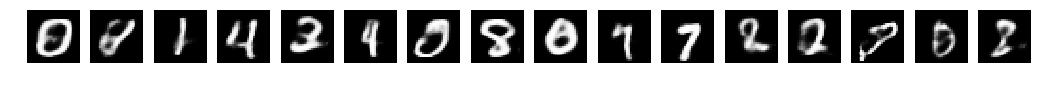

Epoch: 151	L: 93.78
Epoch: 152	L: 93.80
Epoch: 153	L: 93.75
Epoch: 154	L: 93.73
Epoch: 155	L: 93.68
Epoch: 156	L: 93.72
Epoch: 157	L: 93.66
Epoch: 158	L: 93.64
Epoch: 159	L: 93.66
Epoch: 160	L: 93.64
Epoch: 161	L: 93.63
Epoch: 162	L: 93.59
Epoch: 163	L: 93.56
Epoch: 164	L: 93.55
Epoch: 165	L: 93.54
Epoch: 166	L: 93.51
Epoch: 167	L: 93.54
Epoch: 168	L: 93.49
Epoch: 169	L: 93.51
Epoch: 170	L: 93.45
Epoch: 171	L: 93.42
Epoch: 172	L: 93.45
Epoch: 173	L: 93.41
Epoch: 174	L: 93.40
Epoch: 175	L: 93.37
Epoch: 176	L: 93.38
Epoch: 177	L: 93.33
Epoch: 178	L: 93.36
Epoch: 179	L: 93.30
Epoch: 180	L: 93.31
Epoch: 181	L: 93.31
Epoch: 182	L: 93.26
Epoch: 183	L: 93.31
Epoch: 184	L: 93.26
Epoch: 185	L: 93.23
Epoch: 186	L: 93.22
Epoch: 187	L: 93.19
Epoch: 188	L: 93.19
Epoch: 189	L: 93.19
Epoch: 190	L: 93.14
Epoch: 191	L: 93.12
Epoch: 192	L: 93.13
Epoch: 193	L: 93.16
Epoch: 194	L: 93.11
Epoch: 195	L: 93.11
Epoch: 196	L: 93.09
Epoch: 197	L: 93.07
Epoch: 198	L: 93.09
Epoch: 199	L: 93.06
Epoch: 200	L: 93.02


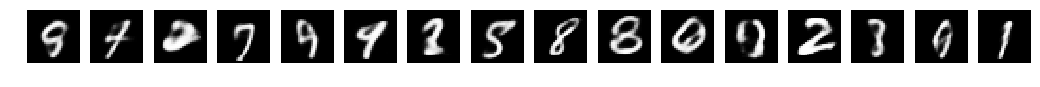

Epoch: 201	L: 92.99
Epoch: 202	L: 93.04
Epoch: 203	L: 92.96
Epoch: 204	L: 92.98
Epoch: 205	L: 92.95
Epoch: 206	L: 92.97
Epoch: 207	L: 92.93
Epoch: 208	L: 92.93
Epoch: 209	L: 92.91
Epoch: 210	L: 92.90
Epoch: 211	L: 92.89
Epoch: 212	L: 92.86
Epoch: 213	L: 92.89
Epoch: 214	L: 92.88
Epoch: 215	L: 92.88
Epoch: 216	L: 92.86
Epoch: 217	L: 92.80
Epoch: 218	L: 92.80
Epoch: 219	L: 92.82
Epoch: 220	L: 92.79
Epoch: 221	L: 92.80
Epoch: 222	L: 92.77
Epoch: 223	L: 92.77
Epoch: 224	L: 92.75
Epoch: 225	L: 92.70
Epoch: 226	L: 92.72
Epoch: 227	L: 92.69
Epoch: 228	L: 92.71
Epoch: 229	L: 92.72
Epoch: 230	L: 92.68
Epoch: 231	L: 92.67
Epoch: 232	L: 92.64
Epoch: 233	L: 92.63
Epoch: 234	L: 92.63
Epoch: 235	L: 92.61
Epoch: 236	L: 92.58
Epoch: 237	L: 92.60
Epoch: 238	L: 92.60
Epoch: 239	L: 92.58
Epoch: 240	L: 92.56
Epoch: 241	L: 92.56
Epoch: 242	L: 92.53
Epoch: 243	L: 92.55
Epoch: 244	L: 92.53
Epoch: 245	L: 92.49
Epoch: 246	L: 92.51
Epoch: 247	L: 92.50
Epoch: 248	L: 92.49
Epoch: 249	L: 92.45
Epoch: 250	L: 92.52


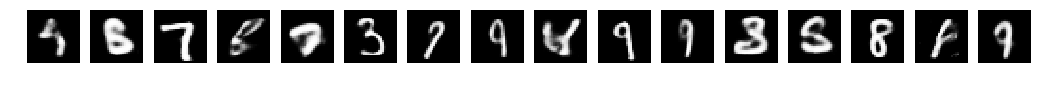

Epoch: 251	L: 92.46
Epoch: 252	L: 92.47
Epoch: 253	L: 92.43
Epoch: 254	L: 92.43
Epoch: 255	L: 92.42
Epoch: 256	L: 92.44
Epoch: 257	L: 92.40
Epoch: 258	L: 92.42
Epoch: 259	L: 92.37
Epoch: 260	L: 92.37
Epoch: 261	L: 92.36
Epoch: 262	L: 92.36
Epoch: 263	L: 92.37
Epoch: 264	L: 92.36
Epoch: 265	L: 92.32
Epoch: 266	L: 92.34
Epoch: 267	L: 92.28
Epoch: 268	L: 92.30
Epoch: 269	L: 92.31
Epoch: 270	L: 92.28
Epoch: 271	L: 92.26
Epoch: 272	L: 92.29
Epoch: 273	L: 92.26
Epoch: 274	L: 92.24
Epoch: 275	L: 92.24
Epoch: 276	L: 92.26
Epoch: 277	L: 92.22
Epoch: 278	L: 92.22
Epoch: 279	L: 92.19
Epoch: 280	L: 92.21
Epoch: 281	L: 92.21
Epoch: 282	L: 92.20
Epoch: 283	L: 92.17
Epoch: 284	L: 92.20
Epoch: 285	L: 92.18
Epoch: 286	L: 92.16
Epoch: 287	L: 92.15
Epoch: 288	L: 92.14
Epoch: 289	L: 92.12
Epoch: 290	L: 92.13
Epoch: 291	L: 92.11
Epoch: 292	L: 92.09
Epoch: 293	L: 92.11
Epoch: 294	L: 92.08
Epoch: 295	L: 92.10
Epoch: 296	L: 92.11
Epoch: 297	L: 92.06
Epoch: 298	L: 92.05
Epoch: 299	L: 92.08
Epoch: 300	L: 92.07


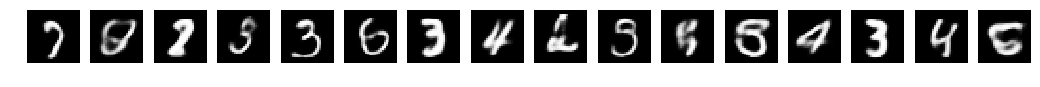

Epoch: 301	L: 92.03
Epoch: 302	L: 92.04
Epoch: 303	L: 92.03
Epoch: 304	L: 92.04
Epoch: 305	L: 92.02
Epoch: 306	L: 92.02
Epoch: 307	L: 92.00
Epoch: 308	L: 92.01
Epoch: 309	L: 91.99
Epoch: 310	L: 91.99
Epoch: 311	L: 91.95
Epoch: 312	L: 91.95
Epoch: 313	L: 91.95
Epoch: 314	L: 91.96
Epoch: 315	L: 91.94
Epoch: 316	L: 91.97
Epoch: 317	L: 91.94
Epoch: 318	L: 91.91
Epoch: 319	L: 91.96
Epoch: 320	L: 91.92
Epoch: 321	L: 91.91
Epoch: 322	L: 91.88
Epoch: 323	L: 91.88
Epoch: 324	L: 91.87
Epoch: 325	L: 91.88
Epoch: 326	L: 91.85
Epoch: 327	L: 91.88
Epoch: 328	L: 91.83
Epoch: 329	L: 91.86
Epoch: 330	L: 91.84
Epoch: 331	L: 91.84
Epoch: 332	L: 91.83
Epoch: 333	L: 91.84
Epoch: 334	L: 91.84
Epoch: 335	L: 91.77
Epoch: 336	L: 91.79
Epoch: 337	L: 91.76
Epoch: 338	L: 91.79
Epoch: 339	L: 91.77
Epoch: 340	L: 91.77
Epoch: 341	L: 91.78
Epoch: 342	L: 91.76
Epoch: 343	L: 91.75
Epoch: 344	L: 91.76
Epoch: 345	L: 91.72
Epoch: 346	L: 91.75
Epoch: 347	L: 91.74
Epoch: 348	L: 91.74
Epoch: 349	L: 91.72
Epoch: 350	L: 91.70


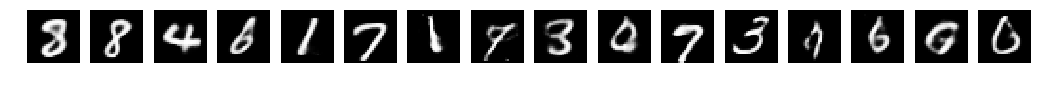

Epoch: 351	L: 91.70
Epoch: 352	L: 91.68
Epoch: 353	L: 91.68
Epoch: 354	L: 91.69
Epoch: 355	L: 91.67
Epoch: 356	L: 91.65
Epoch: 357	L: 91.66
Epoch: 358	L: 91.65
Epoch: 359	L: 91.67
Epoch: 360	L: 91.68
Epoch: 361	L: 91.63
Epoch: 362	L: 91.60
Epoch: 363	L: 91.61
Epoch: 364	L: 91.61
Epoch: 365	L: 91.60
Epoch: 366	L: 91.58
Epoch: 367	L: 91.62
Epoch: 368	L: 91.58
Epoch: 369	L: 91.59
Epoch: 370	L: 91.60
Epoch: 371	L: 91.59
Epoch: 372	L: 91.57
Epoch: 373	L: 91.56
Epoch: 374	L: 91.58
Epoch: 375	L: 91.57
Epoch: 376	L: 91.55
Epoch: 377	L: 91.53
Epoch: 378	L: 91.53
Epoch: 379	L: 91.54
Epoch: 380	L: 91.53
Epoch: 381	L: 91.52
Epoch: 382	L: 91.53
Epoch: 383	L: 91.50
Epoch: 384	L: 91.51
Epoch: 385	L: 91.51
Epoch: 386	L: 91.47
Epoch: 387	L: 91.50
Epoch: 388	L: 91.49
Epoch: 389	L: 91.44
Epoch: 390	L: 91.47
Epoch: 391	L: 91.47
Epoch: 392	L: 91.45
Epoch: 393	L: 91.44
Epoch: 394	L: 91.44
Epoch: 395	L: 91.44
Epoch: 396	L: 91.46
Epoch: 397	L: 91.43
Epoch: 398	L: 91.42
Epoch: 399	L: 91.41
Epoch: 400	L: 91.44


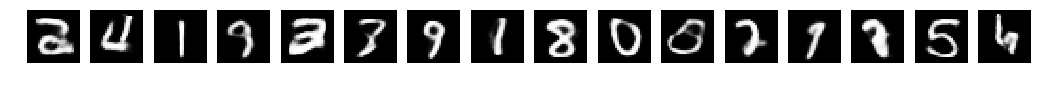

Epoch: 401	L: 91.40
Epoch: 402	L: 91.40
Epoch: 403	L: 91.41
Epoch: 404	L: 91.38
Epoch: 405	L: 91.40
Epoch: 406	L: 91.38
Epoch: 407	L: 91.40
Epoch: 408	L: 91.37
Epoch: 409	L: 91.33
Epoch: 410	L: 91.39
Epoch: 411	L: 91.37
Epoch: 412	L: 91.37
Epoch: 413	L: 91.35
Epoch: 414	L: 91.35
Epoch: 415	L: 91.30
Epoch: 416	L: 91.33
Epoch: 417	L: 91.32
Epoch: 418	L: 91.31
Epoch: 419	L: 91.35
Epoch: 420	L: 91.30
Epoch: 421	L: 91.32
Epoch: 422	L: 91.32
Epoch: 423	L: 91.28
Epoch: 424	L: 91.29
Epoch: 425	L: 91.29
Epoch: 426	L: 91.31
Epoch: 427	L: 91.30
Epoch: 428	L: 91.28
Epoch: 429	L: 91.28
Epoch: 430	L: 91.24
Epoch: 431	L: 91.26
Epoch: 432	L: 91.24
Epoch: 433	L: 91.24
Epoch: 434	L: 91.24
Epoch: 435	L: 91.25
Epoch: 436	L: 91.22
Epoch: 437	L: 91.22
Epoch: 438	L: 91.24
Epoch: 439	L: 91.22
Epoch: 440	L: 91.22
Epoch: 441	L: 91.20
Epoch: 442	L: 91.22
Epoch: 443	L: 91.21
Epoch: 444	L: 91.19
Epoch: 445	L: 91.19
Epoch: 446	L: 91.19
Epoch: 447	L: 91.22
Epoch: 448	L: 91.19
Epoch: 449	L: 91.15
Epoch: 450	L: 91.15


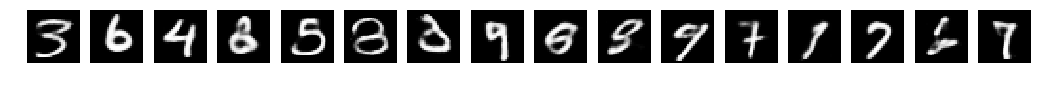

Epoch: 451	L: 91.19
Epoch: 452	L: 91.16
Epoch: 453	L: 91.19
Epoch: 454	L: 91.15
Epoch: 455	L: 91.16
Epoch: 456	L: 91.14
Epoch: 457	L: 91.15
Epoch: 458	L: 91.12
Epoch: 459	L: 91.10
Epoch: 460	L: 91.11
Epoch: 461	L: 91.13
Epoch: 462	L: 91.10
Epoch: 463	L: 91.08
Epoch: 464	L: 91.10
Epoch: 465	L: 91.11
Epoch: 466	L: 91.10
Epoch: 467	L: 91.10
Epoch: 468	L: 91.10
Epoch: 469	L: 91.06
Epoch: 470	L: 91.06
Epoch: 471	L: 91.06
Epoch: 472	L: 91.06
Epoch: 473	L: 91.06
Epoch: 474	L: 91.06
Epoch: 475	L: 91.07
Epoch: 476	L: 91.02
Epoch: 477	L: 91.06
Epoch: 478	L: 91.04
Epoch: 479	L: 91.04
Epoch: 480	L: 91.03
Epoch: 481	L: 91.05
Epoch: 482	L: 91.03
Epoch: 483	L: 91.06
Epoch: 484	L: 90.98
Epoch: 485	L: 91.02
Epoch: 486	L: 91.01
Epoch: 487	L: 91.00
Epoch: 488	L: 91.01
Epoch: 489	L: 90.99
Epoch: 490	L: 91.01
Epoch: 491	L: 91.00
Epoch: 492	L: 91.00
Epoch: 493	L: 90.99
Epoch: 494	L: 90.97
Epoch: 495	L: 90.96
Epoch: 496	L: 90.99
Epoch: 497	L: 90.97
Epoch: 498	L: 90.95
Epoch: 499	L: 90.94
Epoch: 500	L: 90.97


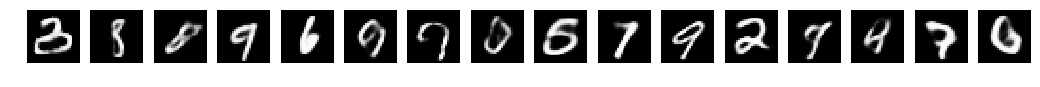

Epoch: 501	L: 90.92
Epoch: 502	L: 90.96
Epoch: 503	L: 90.93
Epoch: 504	L: 90.94
Epoch: 505	L: 90.95
Epoch: 506	L: 90.95
Epoch: 507	L: 90.93
Epoch: 508	L: 90.93
Epoch: 509	L: 90.91
Epoch: 510	L: 90.87
Epoch: 511	L: 90.91
Epoch: 512	L: 90.90
Epoch: 513	L: 90.87
Epoch: 514	L: 90.90
Epoch: 515	L: 90.90
Epoch: 516	L: 90.92
Epoch: 517	L: 90.88
Epoch: 518	L: 90.86
Epoch: 519	L: 90.87
Epoch: 520	L: 90.88
Epoch: 521	L: 90.84
Epoch: 522	L: 90.86
Epoch: 523	L: 90.86
Epoch: 524	L: 90.88
Epoch: 525	L: 90.88
Epoch: 526	L: 90.84
Epoch: 527	L: 90.86
Epoch: 528	L: 90.83
Epoch: 529	L: 90.84
Epoch: 530	L: 90.84
Epoch: 531	L: 90.83
Epoch: 532	L: 90.81
Epoch: 533	L: 90.84
Epoch: 534	L: 90.81
Epoch: 535	L: 90.85
Epoch: 536	L: 90.79
Epoch: 537	L: 90.80
Epoch: 538	L: 90.82
Epoch: 539	L: 90.79
Epoch: 540	L: 90.79
Epoch: 541	L: 90.78
Epoch: 542	L: 90.81
Epoch: 543	L: 90.77
Epoch: 544	L: 90.81
Epoch: 545	L: 90.79
Epoch: 546	L: 90.77
Epoch: 547	L: 90.75
Epoch: 548	L: 90.76
Epoch: 549	L: 90.76
Epoch: 550	L: 90.79


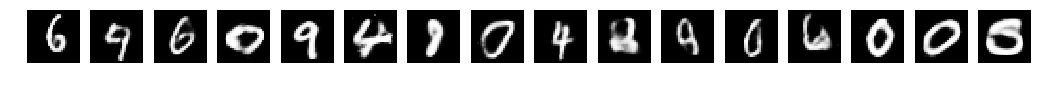

Epoch: 551	L: 90.75
Epoch: 552	L: 90.75
Epoch: 553	L: 90.76
Epoch: 554	L: 90.73
Epoch: 555	L: 90.74
Epoch: 556	L: 90.74
Epoch: 557	L: 90.72
Epoch: 558	L: 90.72
Epoch: 559	L: 90.72
Epoch: 560	L: 90.73
Epoch: 561	L: 90.75
Epoch: 562	L: 90.70
Epoch: 563	L: 90.71
Epoch: 564	L: 90.73
Epoch: 565	L: 90.70
Epoch: 566	L: 90.70
Epoch: 567	L: 90.70
Epoch: 568	L: 90.71
Epoch: 569	L: 90.72
Epoch: 570	L: 90.69
Epoch: 571	L: 90.67
Epoch: 572	L: 90.71
Epoch: 573	L: 90.68
Epoch: 574	L: 90.65
Epoch: 575	L: 90.66
Epoch: 576	L: 90.67
Epoch: 577	L: 90.67
Epoch: 578	L: 90.65
Epoch: 579	L: 90.66
Epoch: 580	L: 90.67
Epoch: 581	L: 90.65
Epoch: 582	L: 90.64
Epoch: 583	L: 90.64
Epoch: 584	L: 90.64
Epoch: 585	L: 90.66
Epoch: 586	L: 90.63
Epoch: 587	L: 90.62
Epoch: 588	L: 90.61
Epoch: 589	L: 90.61
Epoch: 590	L: 90.62
Epoch: 591	L: 90.61
Epoch: 592	L: 90.61
Epoch: 593	L: 90.61
Epoch: 594	L: 90.62
Epoch: 595	L: 90.61
Epoch: 596	L: 90.61
Epoch: 597	L: 90.58
Epoch: 598	L: 90.58
Epoch: 599	L: 90.60
Epoch: 600	L: 90.58


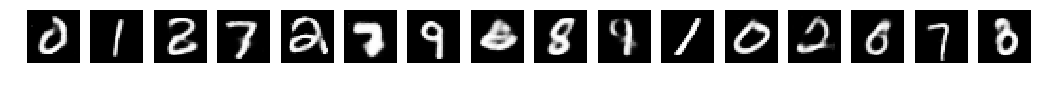

Epoch: 601	L: 90.57
Epoch: 602	L: 90.57
Epoch: 603	L: 90.58
Epoch: 604	L: 90.59
Epoch: 605	L: 90.55
Epoch: 606	L: 90.56
Epoch: 607	L: 90.58
Epoch: 608	L: 90.56
Epoch: 609	L: 90.54
Epoch: 610	L: 90.53
Epoch: 611	L: 90.52
Epoch: 612	L: 90.55
Epoch: 613	L: 90.52
Epoch: 614	L: 90.53
Epoch: 615	L: 90.52
Epoch: 616	L: 90.53
Epoch: 617	L: 90.55
Epoch: 618	L: 90.53
Epoch: 619	L: 90.51
Epoch: 620	L: 90.51
Epoch: 621	L: 90.54
Epoch: 622	L: 90.53
Epoch: 623	L: 90.50
Epoch: 624	L: 90.52
Epoch: 625	L: 90.48
Epoch: 626	L: 90.49
Epoch: 627	L: 90.53
Epoch: 628	L: 90.49
Epoch: 629	L: 90.49
Epoch: 630	L: 90.48
Epoch: 631	L: 90.50
Epoch: 632	L: 90.49
Epoch: 633	L: 90.49
Epoch: 634	L: 90.46
Epoch: 635	L: 90.46
Epoch: 636	L: 90.46
Epoch: 637	L: 90.49
Epoch: 638	L: 90.47
Epoch: 639	L: 90.46
Epoch: 640	L: 90.48
Epoch: 641	L: 90.45
Epoch: 642	L: 90.43
Epoch: 643	L: 90.45
Epoch: 644	L: 90.46
Epoch: 645	L: 90.45
Epoch: 646	L: 90.41
Epoch: 647	L: 90.44
Epoch: 648	L: 90.45
Epoch: 649	L: 90.44
Epoch: 650	L: 90.44


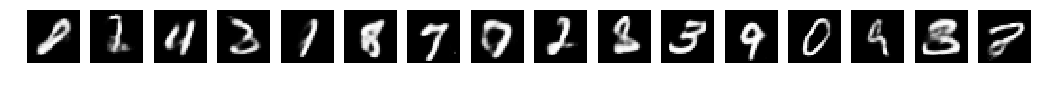

Epoch: 651	L: 90.42
Epoch: 652	L: 90.43
Epoch: 653	L: 90.41
Epoch: 654	L: 90.43
Epoch: 655	L: 90.41
Epoch: 656	L: 90.43
Epoch: 657	L: 90.39
Epoch: 658	L: 90.40
Epoch: 659	L: 90.42
Epoch: 660	L: 90.39
Epoch: 661	L: 90.40
Epoch: 662	L: 90.37
Epoch: 663	L: 90.39
Epoch: 664	L: 90.38
Epoch: 665	L: 90.38
Epoch: 666	L: 90.37
Epoch: 667	L: 90.36
Epoch: 668	L: 90.39
Epoch: 669	L: 90.37
Epoch: 670	L: 90.37
Epoch: 671	L: 90.37
Epoch: 672	L: 90.35
Epoch: 673	L: 90.31
Epoch: 674	L: 90.34
Epoch: 675	L: 90.34
Epoch: 676	L: 90.32
Epoch: 677	L: 90.34
Epoch: 678	L: 90.35
Epoch: 679	L: 90.35
Epoch: 680	L: 90.32
Epoch: 681	L: 90.35
Epoch: 682	L: 90.34
Epoch: 683	L: 90.32
Epoch: 684	L: 90.32
Epoch: 685	L: 90.29
Epoch: 686	L: 90.32
Epoch: 687	L: 90.32
Epoch: 688	L: 90.34
Epoch: 689	L: 90.31
Epoch: 690	L: 90.33
Epoch: 691	L: 90.31
Epoch: 692	L: 90.30
Epoch: 693	L: 90.30
Epoch: 694	L: 90.30
Epoch: 695	L: 90.30
Epoch: 696	L: 90.30
Epoch: 697	L: 90.31
Epoch: 698	L: 90.30
Epoch: 699	L: 90.29
Epoch: 700	L: 90.28


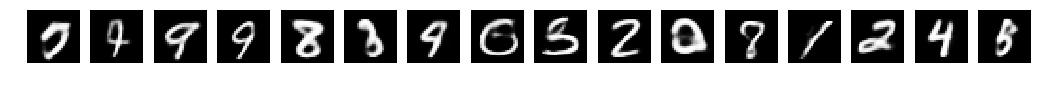

Epoch: 701	L: 90.28
Epoch: 702	L: 90.26
Epoch: 703	L: 90.27
Epoch: 704	L: 90.25
Epoch: 705	L: 90.25
Epoch: 706	L: 90.25
Epoch: 707	L: 90.25
Epoch: 708	L: 90.24
Epoch: 709	L: 90.25
Epoch: 710	L: 90.27
Epoch: 711	L: 90.20
Epoch: 712	L: 90.26
Epoch: 713	L: 90.23
Epoch: 714	L: 90.20
Epoch: 715	L: 90.25
Epoch: 716	L: 90.25
Epoch: 717	L: 90.24
Epoch: 718	L: 90.20
Epoch: 719	L: 90.22
Epoch: 720	L: 90.21
Epoch: 721	L: 90.20
Epoch: 722	L: 90.20
Epoch: 723	L: 90.23
Epoch: 724	L: 90.24
Epoch: 725	L: 90.19
Epoch: 726	L: 90.19
Epoch: 727	L: 90.22
Epoch: 728	L: 90.18
Epoch: 729	L: 90.19
Epoch: 730	L: 90.19
Epoch: 731	L: 90.21
Epoch: 732	L: 90.18
Epoch: 733	L: 90.18
Epoch: 734	L: 90.20
Epoch: 735	L: 90.22
Epoch: 736	L: 90.17
Epoch: 737	L: 90.18
Epoch: 738	L: 90.15
Epoch: 739	L: 90.18
Epoch: 740	L: 90.16
Epoch: 741	L: 90.18
Epoch: 742	L: 90.17
Epoch: 743	L: 90.16
Epoch: 744	L: 90.17
Epoch: 745	L: 90.14
Epoch: 746	L: 90.14
Epoch: 747	L: 90.16
Epoch: 748	L: 90.12
Epoch: 749	L: 90.15
Epoch: 750	L: 90.15


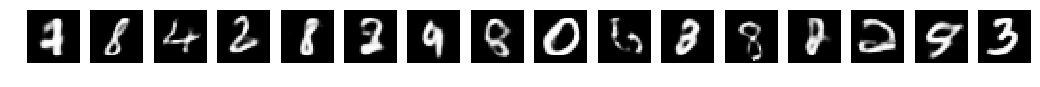

Epoch: 751	L: 90.13
Epoch: 752	L: 90.14
Epoch: 753	L: 90.14
Epoch: 754	L: 90.13
Epoch: 755	L: 90.14
Epoch: 756	L: 90.14
Epoch: 757	L: 90.11
Epoch: 758	L: 90.10
Epoch: 759	L: 90.12
Epoch: 760	L: 90.10
Epoch: 761	L: 90.13
Epoch: 762	L: 90.09
Epoch: 763	L: 90.12
Epoch: 764	L: 90.11
Epoch: 765	L: 90.08
Epoch: 766	L: 90.10
Epoch: 767	L: 90.10
Epoch: 768	L: 90.07
Epoch: 769	L: 90.09
Epoch: 770	L: 90.10
Epoch: 771	L: 90.08
Epoch: 772	L: 90.07
Epoch: 773	L: 90.08
Epoch: 774	L: 90.08
Epoch: 775	L: 90.11
Epoch: 776	L: 90.08
Epoch: 777	L: 90.07
Epoch: 778	L: 90.06
Epoch: 779	L: 90.07
Epoch: 780	L: 90.04
Epoch: 781	L: 90.05
Epoch: 782	L: 90.06
Epoch: 783	L: 90.08
Epoch: 784	L: 90.06
Epoch: 785	L: 90.05
Epoch: 786	L: 90.05
Epoch: 787	L: 90.05
Epoch: 788	L: 90.05
Epoch: 789	L: 90.06
Epoch: 790	L: 90.05
Epoch: 791	L: 90.04
Epoch: 792	L: 90.02
Epoch: 793	L: 90.04
Epoch: 794	L: 90.03
Epoch: 795	L: 90.05
Epoch: 796	L: 90.04
Epoch: 797	L: 90.01
Epoch: 798	L: 89.99
Epoch: 799	L: 90.04
Epoch: 800	L: 90.00


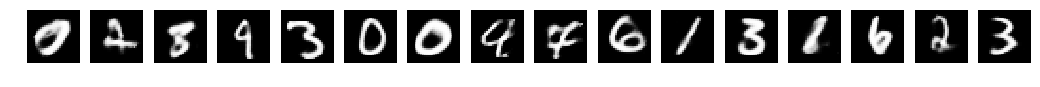

Epoch: 801	L: 90.02
Epoch: 802	L: 89.98
Epoch: 803	L: 89.98
Epoch: 804	L: 90.00
Epoch: 805	L: 90.00
Epoch: 806	L: 90.01
Epoch: 807	L: 89.97
Epoch: 808	L: 90.01
Epoch: 809	L: 90.02
Epoch: 810	L: 89.98
Epoch: 811	L: 90.00
Epoch: 812	L: 90.00
Epoch: 813	L: 89.99
Epoch: 814	L: 89.98
Epoch: 815	L: 89.98
Epoch: 816	L: 89.99
Epoch: 817	L: 89.97
Epoch: 818	L: 89.95
Epoch: 819	L: 89.97
Epoch: 820	L: 90.00
Epoch: 821	L: 89.97
Epoch: 822	L: 89.99
Epoch: 823	L: 89.95
Epoch: 824	L: 89.94
Epoch: 825	L: 89.94
Epoch: 826	L: 89.94
Epoch: 827	L: 89.95
Epoch: 828	L: 89.94
Epoch: 829	L: 89.96
Epoch: 830	L: 89.93
Epoch: 831	L: 89.92
Epoch: 832	L: 89.94
Epoch: 833	L: 89.94
Epoch: 834	L: 89.94
Epoch: 835	L: 89.91
Epoch: 836	L: 89.93
Epoch: 837	L: 89.91
Epoch: 838	L: 89.93
Epoch: 839	L: 89.94
Epoch: 840	L: 89.92
Epoch: 841	L: 89.93
Epoch: 842	L: 89.91
Epoch: 843	L: 89.90
Epoch: 844	L: 89.95
Epoch: 845	L: 89.91
Epoch: 846	L: 89.90
Epoch: 847	L: 89.90
Epoch: 848	L: 89.89
Epoch: 849	L: 89.90
Epoch: 850	L: 89.89


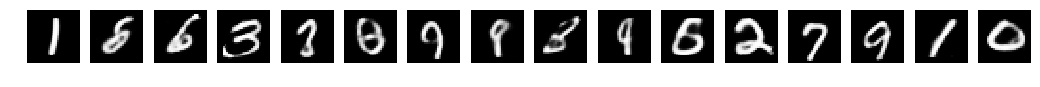

Epoch: 851	L: 89.92
Epoch: 852	L: 89.90
Epoch: 853	L: 89.90
Epoch: 854	L: 89.87
Epoch: 855	L: 89.88
Epoch: 856	L: 89.90
Epoch: 857	L: 89.91
Epoch: 858	L: 89.85
Epoch: 859	L: 89.89
Epoch: 860	L: 89.87
Epoch: 861	L: 89.87
Epoch: 862	L: 89.84
Epoch: 863	L: 89.87
Epoch: 864	L: 89.86
Epoch: 865	L: 89.86
Epoch: 866	L: 89.84
Epoch: 867	L: 89.85
Epoch: 868	L: 89.85
Epoch: 869	L: 89.85
Epoch: 870	L: 89.86
Epoch: 871	L: 89.85
Epoch: 872	L: 89.83
Epoch: 873	L: 89.85
Epoch: 874	L: 89.85
Epoch: 875	L: 89.82
Epoch: 876	L: 89.83
Epoch: 877	L: 89.84
Epoch: 878	L: 89.84
Epoch: 879	L: 89.82
Epoch: 880	L: 89.83
Epoch: 881	L: 89.83
Epoch: 882	L: 89.83
Epoch: 883	L: 89.82
Epoch: 884	L: 89.82
Epoch: 885	L: 89.82
Epoch: 886	L: 89.81
Epoch: 887	L: 89.80
Epoch: 888	L: 89.81
Epoch: 889	L: 89.82
Epoch: 890	L: 89.79
Epoch: 891	L: 89.78
Epoch: 892	L: 89.82
Epoch: 893	L: 89.78
Epoch: 894	L: 89.81
Epoch: 895	L: 89.83
Epoch: 896	L: 89.79
Epoch: 897	L: 89.79
Epoch: 898	L: 89.75
Epoch: 899	L: 89.81
Epoch: 900	L: 89.79


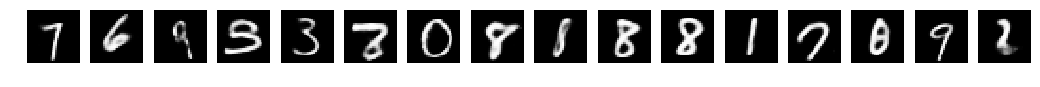

Epoch: 901	L: 89.81
Epoch: 902	L: 89.80
Epoch: 903	L: 89.79
Epoch: 904	L: 89.77
Epoch: 905	L: 89.78
Epoch: 906	L: 89.78
Epoch: 907	L: 89.78
Epoch: 908	L: 89.78
Epoch: 909	L: 89.79
Epoch: 910	L: 89.75
Epoch: 911	L: 89.76
Epoch: 912	L: 89.74
Epoch: 913	L: 89.76
Epoch: 914	L: 89.75
Epoch: 915	L: 89.76
Epoch: 916	L: 89.75
Epoch: 917	L: 89.75
Epoch: 918	L: 89.76
Epoch: 919	L: 89.78
Epoch: 920	L: 89.75
Epoch: 921	L: 89.76
Epoch: 922	L: 89.75
Epoch: 923	L: 89.75
Epoch: 924	L: 89.74
Epoch: 925	L: 89.75
Epoch: 926	L: 89.72
Epoch: 927	L: 89.75
Epoch: 928	L: 89.71
Epoch: 929	L: 89.73
Epoch: 930	L: 89.71
Epoch: 931	L: 89.72
Epoch: 932	L: 89.75
Epoch: 933	L: 89.72
Epoch: 934	L: 89.74
Epoch: 935	L: 89.70
Epoch: 936	L: 89.71
Epoch: 937	L: 89.72
Epoch: 938	L: 89.71
Epoch: 939	L: 89.72
Epoch: 940	L: 89.72
Epoch: 941	L: 89.70
Epoch: 942	L: 89.71
Epoch: 943	L: 89.69
Epoch: 944	L: 89.69
Epoch: 945	L: 89.70
Epoch: 946	L: 89.69
Epoch: 947	L: 89.71
Epoch: 948	L: 89.68
Epoch: 949	L: 89.73
Epoch: 950	L: 89.71


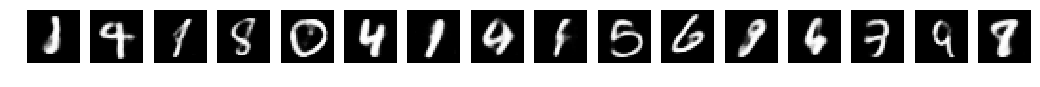

Epoch: 951	L: 89.70
Epoch: 952	L: 89.70
Epoch: 953	L: 89.65
Epoch: 954	L: 89.69
Epoch: 955	L: 89.69
Epoch: 956	L: 89.65
Epoch: 957	L: 89.65
Epoch: 958	L: 89.70
Epoch: 959	L: 89.63
Epoch: 960	L: 89.64
Epoch: 961	L: 89.65
Epoch: 962	L: 89.68
Epoch: 963	L: 89.67
Epoch: 964	L: 89.69
Epoch: 965	L: 89.65
Epoch: 966	L: 89.67
Epoch: 967	L: 89.66
Epoch: 968	L: 89.67
Epoch: 969	L: 89.66
Epoch: 970	L: 89.64
Epoch: 971	L: 89.64
Epoch: 972	L: 89.64
Epoch: 973	L: 89.64
Epoch: 974	L: 89.63
Epoch: 975	L: 89.65
Epoch: 976	L: 89.62
Epoch: 977	L: 89.66
Epoch: 978	L: 89.60
Epoch: 979	L: 89.65
Epoch: 980	L: 89.66
Epoch: 981	L: 89.63
Epoch: 982	L: 89.64
Epoch: 983	L: 89.63
Epoch: 984	L: 89.62
Epoch: 985	L: 89.61
Epoch: 986	L: 89.65
Epoch: 987	L: 89.64
Epoch: 988	L: 89.62
Epoch: 989	L: 89.62
Epoch: 990	L: 89.62
Epoch: 991	L: 89.63
Epoch: 992	L: 89.61
Epoch: 993	L: 89.62
Epoch: 994	L: 89.63
Epoch: 995	L: 89.60
Epoch: 996	L: 89.61
Epoch: 997	L: 89.61
Epoch: 998	L: 89.60
Epoch: 999	L: 89.60
Epoch: 1000	L: 89.60

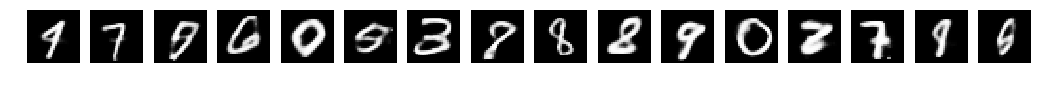

In [5]:
from tqdm import tnrange

torch.multiprocessing.set_sharing_strategy('file_system')

for epoch in tnrange(1001):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda()

        reconstruction = model(u)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()

    m = len(train)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")
    
    if epoch % 50 == 0:
        model.eval()
        x_mu = model.sample(Variable(torch.randn(16, 50)).cuda())
        f, axarr = plt.subplots(1, 16, figsize=(18, 12))
        samples = x_mu.data.cpu().numpy().reshape(-1, 28, 28)
        
        # mnist_means = np.tile(mnist_mean.reshape((1, -1)), (len(samples), 1))
        # mnist_means[:, mnist_std > 0.1] = samples
        # samples = mnist_means.reshape(-1, 28, 28)

        # samples = x_mu.data.view(-1, 3, 32, 32).cpu().numpy().transpose(0, 2, 3, 1)
        for i, ax in enumerate(axarr.flat):
            ax.imshow(samples[i], cmap="gray")
            ax.axis("off")
        plt.show()

## Sampling from the generative model

Now that we have trained the network, we can begin to sample from it. We simply give it some random noise distributed according to the prior $p(z) = \mathcal{N}(0, I)$ and send it through the decoder. This process generates a slew of samples that look like they come from the original distribution $p(x)$.

In [6]:
# torch.save(model.state_dict(), "vae_mnist_new.ckpt")

In [7]:
print(epoch)

1000
